<a href="https://colab.research.google.com/github/prembalaji069/Lead/blob/master/Intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                DATA Emotions
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness


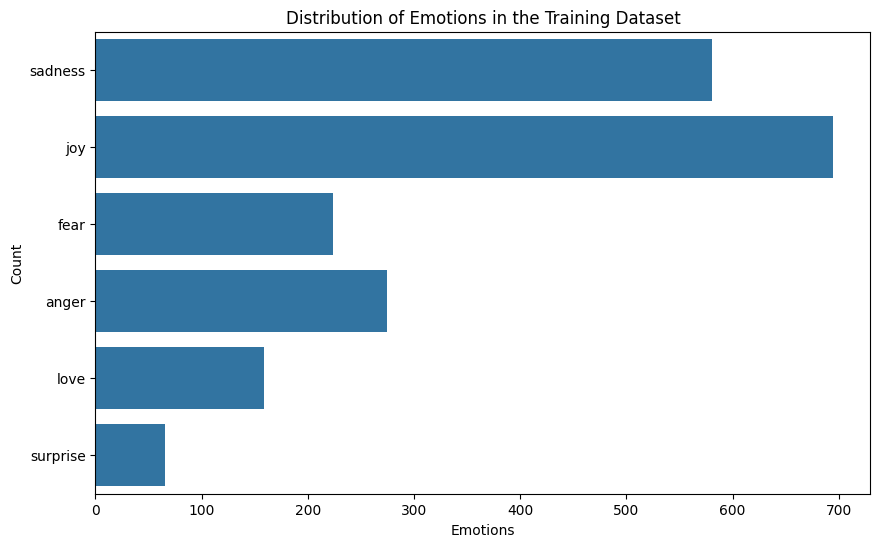

Epoch 1/10
50/50 [==============================] - 5s 66ms/step - loss: 1.5916 - accuracy: 0.3288 - val_loss: 1.5666 - val_accuracy: 0.3225
Epoch 2/10
50/50 [==============================] - 3s 54ms/step - loss: 1.3861 - accuracy: 0.4988 - val_loss: 1.5516 - val_accuracy: 0.3825
Epoch 3/10
50/50 [==============================] - 3s 56ms/step - loss: 0.9296 - accuracy: 0.7150 - val_loss: 1.5275 - val_accuracy: 0.4225
Epoch 4/10
50/50 [==============================] - 2s 31ms/step - loss: 0.3866 - accuracy: 0.9319 - val_loss: 1.6077 - val_accuracy: 0.4075
Epoch 5/10
50/50 [==============================] - 1s 25ms/step - loss: 0.1248 - accuracy: 0.9831 - val_loss: 1.6759 - val_accuracy: 0.4075
Epoch 6/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0505 - accuracy: 0.9950 - val_loss: 1.6417 - val_accuracy: 0.4400
Epoch 7/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 1.6871 - val_accuracy: 0.4400
Epoch 8/10
50

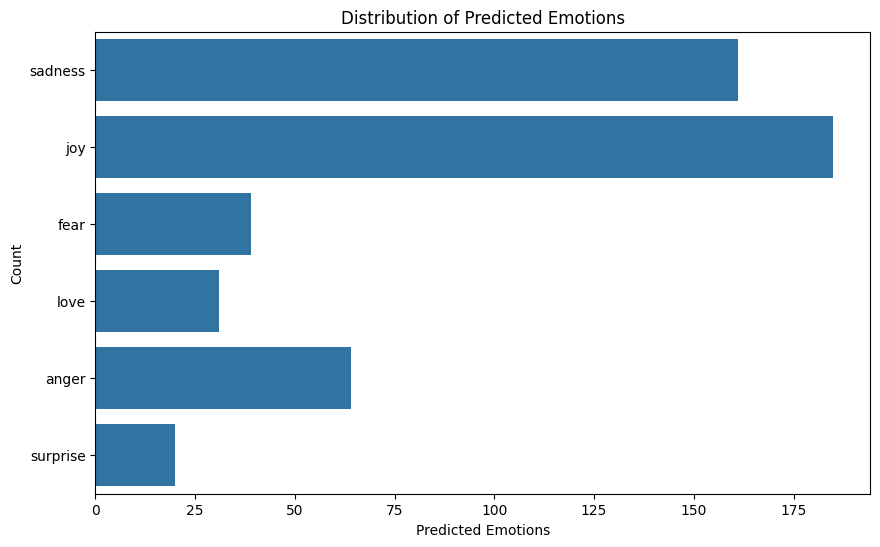

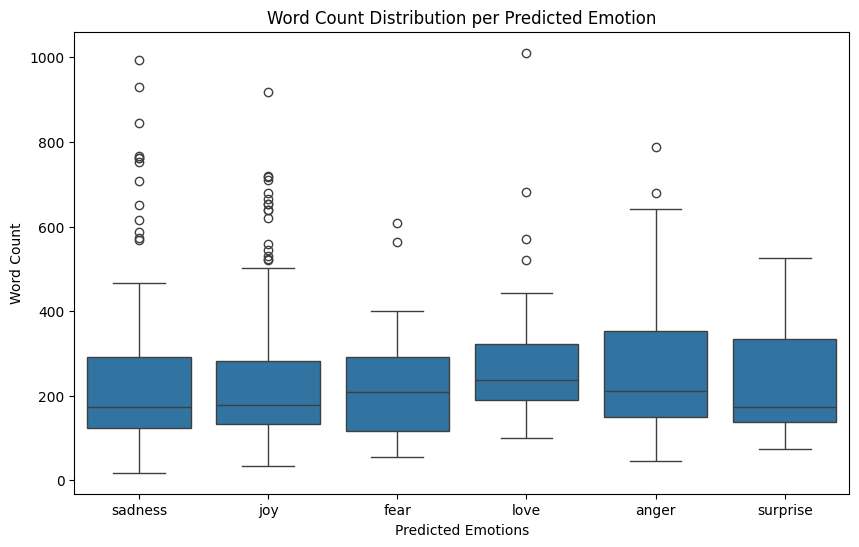

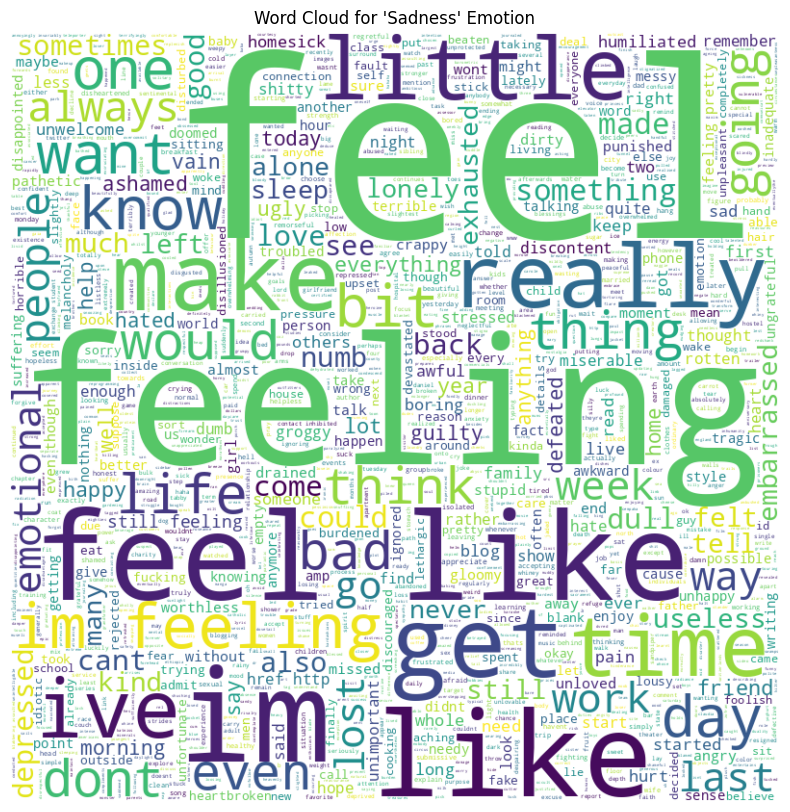

Results saved to /content/output_with_predictions.csv


In [20]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

# Define English stopwords
eng_stopwords = set(stopwords.words("english"))

# Read the CSV file
data = pd.read_csv("/content/train.csv")
print(data.head())

# Plot the distribution of emotions in the training data
plt.figure(figsize=(10, 6))
sns.countplot(data['Emotions'])
plt.title('Distribution of Emotions in the Training Dataset')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

texts = data["DATA"].tolist()
labels = data["Emotions"].tolist()

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Encode the string labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# One-hot encode the labels
one_hot_labels = keras.utils.to_categorical(labels)

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(padded_sequences, one_hot_labels, test_size=0.2)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=len(one_hot_labels[0]), activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xtest, ytest))

# Create a mock word intensity lexicon
word_intensity_lexicon = {
    'happy': 0.9,
    'sad': 0.8,
    'angry': 0.85,
    'joy': 0.7,
    'disappointed': 0.75
}

# Read the input file for prediction, trying different encodings
input_file = "/content/Input.csv"
try:
    input_data = pd.read_csv(input_file, encoding='utf-8')
except UnicodeDecodeError:
    try:
        input_data = pd.read_csv(input_file, encoding='latin-1')
    except UnicodeDecodeError:
        input_data = pd.read_csv(input_file, encoding='utf-16')  # Or try other encodings if needed

input_texts = input_data["DATA"].tolist()  # Assuming 'DATA' is the column with text

# Preprocess the input text data and predict emotions
predicted_emotions = []
emotion_word_counts = []
emotion_intensity = []

for input_text in input_texts:
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length)
    prediction = model.predict(padded_input_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction[0])])
    predicted_emotions.append(predicted_label[0])

    # Count words associated with the predicted emotion
    words = input_text.split()
    word_count = len(words)
    emotion_word_counts.append(word_count)

    # Calculate intensity
    total_intensity = sum(word_intensity_lexicon.get(word, 0) for word in words)
    count = sum(1 for word in words if word in word_intensity_lexicon)
    avg_intensity = total_intensity / count if count > 0 else 0
    emotion_intensity.append(avg_intensity)

# Add the predicted emotions, word counts, and intensities to the input data
input_data['Predicted_Emotions'] = predicted_emotions
input_data['Word_Count'] = emotion_word_counts
input_data['Emotion_Intensity'] = emotion_intensity

# Save the new CSV file with predicted emotions, word counts, and intensities
output_file = "/content/output_with_predictions.csv"
input_data.to_csv(output_file, index=False)

# Plot the distribution of predicted emotions
plt.figure(figsize=(10, 6))
sns.countplot(input_data['Predicted_Emotions'])
plt.title('Distribution of Predicted Emotions')
plt.xlabel('Predicted Emotions')
plt.ylabel('Count')
plt.show()

# Plot the distribution of word counts per emotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predicted_Emotions', y='Word_Count', data=input_data)
plt.title('Word Count Distribution per Predicted Emotion')
plt.xlabel('Predicted Emotions')
plt.ylabel('Word Count')
plt.show()

# Create a word cloud for 'sadness' emotion
wordcloud = WordCloud(
    stopwords=eng_stopwords,
    max_font_size=256,
    max_words=2000,
    background_color="white",
    width=800,
    height=800,
    random_state=42
).generate(' '.join(data['DATA'][data['Emotions'] == 'sadness']))

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud for 'Sadness' Emotion")
plt.axis("off")
plt.show()

print(f'Results saved to {output_file}')
